# Parsing normalised difference indices
Final step in post processing for vegetation and irrigation markers from NIR calculated from cGAN images.
The aim is to be able to classify the index values into vegetation and irrigation markers so we can provide more actionable results to the end user.

In [69]:
import os
import cv2
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [70]:
dataset_path = pathlib.Path("/Users/adambyrne/Datasets/nirscene0x/train")
image_data = tf.io.read_file(str(dataset_path / "country_0017.jpg"))
image = tf.io.decode_jpeg(image_data)

In [71]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    input_image = tf.image.resize(input_image, [256, 256])
    real_image = tf.image.resize(real_image, [256, 256])

    return real_image, input_image

# Sample images from the training set

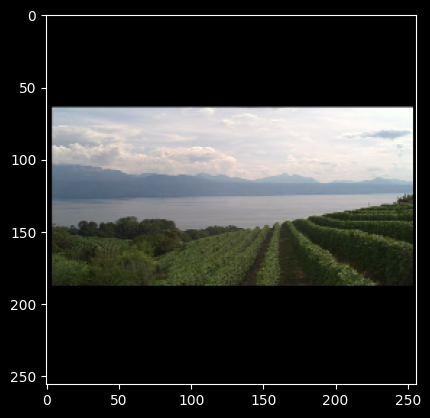

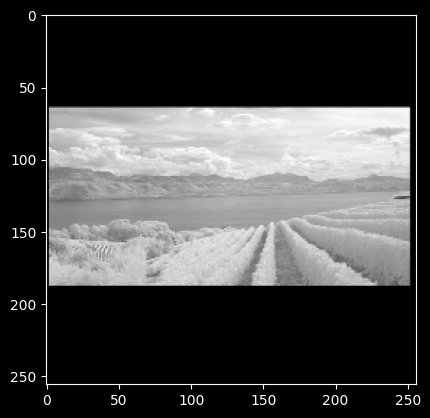

In [72]:
inp, re = load(str(dataset_path / "country_0017.jpg"))
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

# NDVI calculated from NIR and RED bands
`NDVI = (NIR - RED) / (NIR + RED)`

Normalised difference vegetation index (NDVI) is a simple graphical indicator that can be used to analyse remote sensing measurements, typically but not necessarily from a space platform, and assess whether the target being observed contains live green vegetation or not.

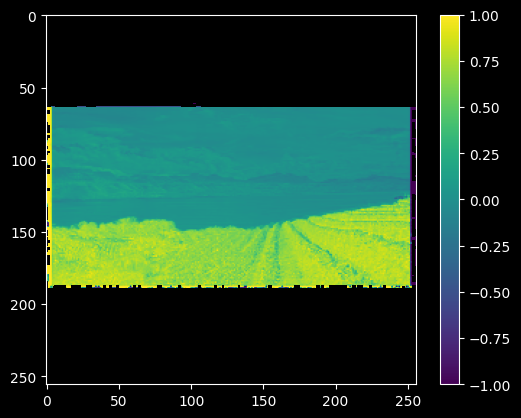

In [73]:
ndvi = (re[:, :, 0] - inp[:, :, 2]) / (re[:, :, 0] + inp[:, :, 2])

plt.figure()
plt.imshow(ndvi)
plt.colorbar()

# NDWI calculated from NIR and GREEN bands
`NDWI = (GREEN - NIR) / (GREEN + NIR)`

The Normalized Difference Water Index (NDWI) is a normalized ratio of the green and NIR bands designed to enhance water features and suppress land features.

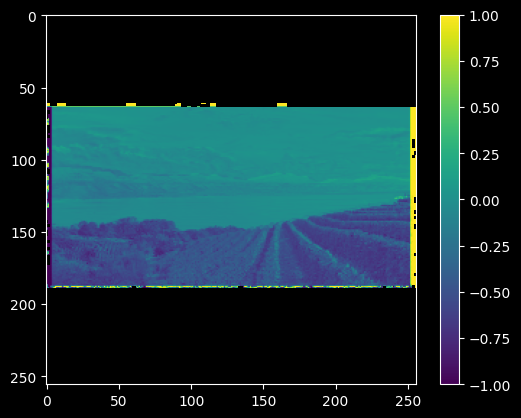

In [74]:
ndwi = (inp[:, :, 1] - re[:, :, 2]) / (inp[:, :, 1] + re[:, :, 2])

plt.figure()
plt.imshow(ndwi)
plt.colorbar()

# Parsing indices into labelled regions
Identify clusters of similar indices and label them as vegetation or irrigation markers.


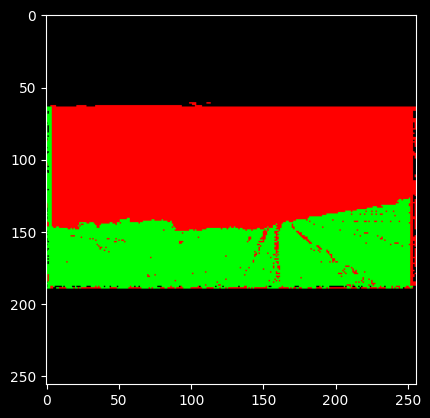

In [75]:
ndvi_regions = np.zeros((256, 256, 3))
ndvi_regions[ndvi > 0.5, 1] = 1
ndvi_regions[ndvi < 0.5, 0] = 1
plt.imshow(ndvi_regions)

Here we can now identify the clusters of healthy vegetation with thresholding

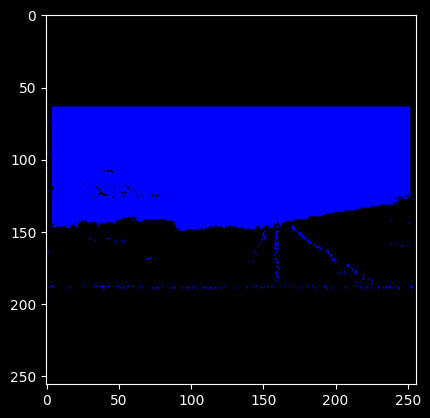

In [76]:
ndwi_regions = np.zeros((256, 256, 3))
ndwi_regions[(ndwi > -0.25) & (ndwi < 0.25), 2] = 1

plt.imshow(ndwi_regions)

Given the output before the regions this is not surprising as no water pathways were found in this image with the exception of few pixels in the sky.

## Parser

In [77]:
def parse_indices(inp, re, regions=False):
    ndvi = (re[:, :, 0] - inp[:, :, 2]) / (re[:, :, 0] + inp[:, :, 2])
    ndwi = (inp[:, :, 1] - re[:, :, 2]) / (inp[:, :, 1] + re[:, :, 2])
    
    if regions is False:
        return ndvi, ndwi
    
    ndvi_regions = np.zeros((256, 256, 3))
    ndvi_regions[ndvi > 0.5, 1] = 1
    ndvi_regions[ndvi < 0.5, 0] = 1
    
    ndwi_regions = np.zeros((256, 256, 3))
    ndwi_regions[(ndwi > -0.25) & (ndwi < 0.25), 2] = 1
    
    return ndvi, ndwi, ndvi_regions, ndwi_regions

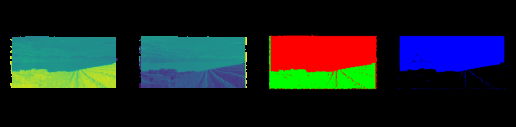

In [78]:
indices = parse_indices(inp, re, regions=True)

fig, axs = plt.subplots(1, len(indices))
for i, img in enumerate(indices):
    axs[i].imshow(img)
    axs[i].axis('off')